In [10]:
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import heapq
import signal

### Exercice 1 – Branch and Bound pour le problème du sac à dos 0/1
On vous demande dans cet exercice de programmer un algorithme de Branch & Bound pour résoudre le
problème du sac à dos 0/1. Vous testerez d’abord votre algorithme sur les données du cours, puis sur celles
utilisées lors de la séance précédente, et vous comparerez les temps de calcul. Vous pourrez également comparer
les 3 stratégies de branchement vues en cours.

Pistes : pour mon code, je me suis appuyé sur les deux classes suivantes (rien ne vous y oblige naturellement)

Avertissement : peu de chance que vous triomphiez de ce problème sans écrire au préalable un algorithme sur
papier

In [2]:
class TreeNode:
    def __init__(self, level, V, W, taken, upper_bound=None):
        self.level = level  # niveau dans l’arbre de recherche >=0
        self.V = V  # valeur de la solution courante
        self.W = W  # poids de la solution courante
        self.taken = taken  # liste des index d’objets de la solution courante
        self.upper_bound = upper_bound  # Upper Bound of the solution (for Best First method)

    def __lt__(self, other):
        return (self.upper_bound or 0) > (other.upper_bound or 0)  # Highest bound has priority

In [3]:
class KPBB_BreadthFirst:
    def __init__(self, cap, values, weights): 
        self.capacity = cap
        self.values = values
        self.weights = weights
        self.unordered = [((v, w), i) for i, (v, w) in enumerate(zip(self.values, self.weights))]
        self.ordered = sorted([((v, w), i) for i, (v, w) in enumerate(zip(self.values, self.weights))], key=lambda tup: float(tup[0][0])/tup[0][1], reverse=True)
    
    def initialSolution(self):  # calcul de la solution initiale by greedy
        W = self.capacity 
        result = 0
        for item in self.ordered: # for each item,
            if W - item[0][1] >= 0: # if it fits the sac a dos
                result += item[0][0] # adds it to the sac a dos 
                W -= item[0][1] # reduces the capacity
        return result
    
    def UpperBound(self, node):  # calcul UpperBound
        W = self.capacity - node.W  # remaining capacity
        result = node.V  
        i = node.level + 1 # next level
        
        while i < len(self.ordered) and self.ordered[i][0][1] <= W: # while there are itens left and it fits
            W -= self.ordered[i][0][1] # reduces capacity
            result += self.ordered[i][0][0] # ads it to the sac a dos
            i += 1 # goes to next item
        
        if i < len(self.ordered): # when no more itens fits, ads a fraction of the following item
            result += self.ordered[i][0][0] * (W / self.ordered[i][0][1]) 

        return result
    
    def nodeEvaluation(self, index, node): # fonction d’évaluation d’un noeud
        if node.W <= self.capacity and node.V > self.bestValue:  # if item fits and has a better value
            self.bestValue = node.V  # sets as new best
            self.bestTaken = node.taken  # set new chosen itens
        
        if node.W <= self.capacity: # if node fits
            upper_bound = self.UpperBound(node) # calculate the upper bound
            return upper_bound
        else:
            return 0  # if it doesent fit, cut the tree branch

    def solve(self): # algorithme de résolution
        root = TreeNode(-1, 0, 0, [])  # root node
        queue = [root]  # queue of nodes
        
        self.bestValue = 0  
        self.bestTaken = []  

        self.n_it = 0
        
        while queue:  # while there are itens in the queue
            node = queue.pop(0)  # takes the first node (breadth first)
            self.n_it = self.n_it + 1

            if node.level < len(self.ordered) - 1: # if is not the last item
                # first branch: dont take the item
                nodeLeft = TreeNode(node.level + 1, node.V, node.W, node.taken[:]) # create the node just like the current one
                upperLeft = self.nodeEvaluation(nodeLeft.level, nodeLeft)  # calcul upperbound
                
                if upperLeft > self.bestValue:  # if the upperbound is better, adds it to the list
                    queue.append(nodeLeft)

                # second branch: take the item
                item = self.ordered[node.level + 1] # next item
                nodeRight = TreeNode(node.level + 1, node.V + item[0][0], node.W + item[0][1], node.taken + [item[1]]) # create node with next item
                upperRight = self.nodeEvaluation(nodeRight.level, nodeRight)  # cálculo upperbound
                
                if upperRight > self.bestValue:  # if the upperbound is better, adds it to the list
                    queue.append(nodeRight)
        
        return self.bestValue, self.bestTaken, self.n_it


In [4]:
class KPBB_DepthFirst:
    def __init__(self, cap, values, weights): 
        self.capacity = cap
        self.values = values
        self.weights = weights
        self.unordered = [((v, w), i) for i, (v, w) in enumerate(zip(self.values, self.weights))]
        # Ordenação dos itens com base na relação valor/peso (ganância)
        self.ordered = sorted(self.unordered, key=lambda tup: float(tup[0][0]) / tup[0][1], reverse=True)
    
    def UpperBound(self, node):  # Cálculo do limite superior (Upper Bound)
        W = self.capacity - node.W  # Peso restante
        result = node.V  # Valor atual
        i = node.level + 1  # Próximo item a ser considerado
        
        while i < len(self.ordered) and self.ordered[i][0][1] <= W:
            W -= self.ordered[i][0][1]
            result += self.ordered[i][0][0]
            i += 1
        
        if i < len(self.ordered):
            result += self.ordered[i][0][0] * (W / self.ordered[i][0][1])  # Fração do item

        return result
    
    def nodeEvaluation(self, node):  # Avaliação do nó na árvore de busca
        if node.W <= self.capacity and node.V > self.bestValue:  # Se a solução for válida e melhor
            self.bestValue = node.V  # Atualiza o melhor valor
            self.bestTaken = node.taken  # Atualiza os itens escolhidos
        
        return self.UpperBound(node) if node.W <= self.capacity else 0  # Retorna upper bound

    def solve(self):  # Algoritmo de Branch & Bound (DFS)
        root = TreeNode(-1, 0, 0, [])  # Nó raiz
        stack = [root]  # Pilha de nós a serem explorados
        
        self.bestValue = 0  # Melhor valor encontrado
        self.bestTaken = []  # Itens da melhor solução

        self.n_it = 0
        
        while stack:  # Enquanto houver nós na pilha
            node = stack.pop()  # Remove o último nó adicionado (DFS)
            self.n_it = self.n_it + 1

            if node.level < len(self.ordered) - 1:
                # Caso 1: Incluir o item
                item = self.ordered[node.level + 1]
                nodeRight = TreeNode(node.level + 1, node.V + item[0][0], node.W + item[0][1], node.taken + [item[1]])
                upperRight = self.nodeEvaluation(nodeRight)

                if upperRight > self.bestValue:  # Se o upper bound for promissor
                    stack.append(nodeRight)  # Adiciona na pilha (DFS)

                # Caso 2: Não incluir o item
                nodeLeft = TreeNode(node.level + 1, node.V, node.W, node.taken[:])
                upperLeft = self.nodeEvaluation(nodeLeft)

                if upperLeft > self.bestValue:  # Se o upper bound for promissor
                    stack.append(nodeLeft)  # Adiciona na pilha (DFS)
        
        return self.bestValue, self.bestTaken, self.n_it 

In [5]:
class KPBB_BestFirst:
    def __init__(self, cap, values, weights): 
        self.capacity = cap
        self.values = values
        self.weights = weights
        self.unordered = [((v, w), i) for i, (v, w) in enumerate(zip(self.values, self.weights))]
        self.ordered = sorted(self.unordered, key=lambda tup: float(tup[0][0])/tup[0][1], reverse=True)

    def UpperBound(self, node):
        W = self.capacity - node.W
        result = node.V
        i = node.level + 1
        
        while i < len(self.ordered) and self.ordered[i][0][1] <= W:
            W -= self.ordered[i][0][1]
            result += self.ordered[i][0][0]
            i += 1
        
        if i < len(self.ordered):
            result += self.ordered[i][0][0] * (W / self.ordered[i][0][1])

        return result

    def solve(self):
        root = TreeNode(-1, 0, 0, [], self.UpperBound(TreeNode(-1, 0, 0, [], 0)))  # Corrigido
        pq = []
        heapq.heappush(pq, root)

        self.bestValue = 0
        self.bestTaken = []

        self.n_it = 0

        while pq:
            node = heapq.heappop(pq)
            self.n_it = self.n_it + 1

            if node.upper_bound <= self.bestValue:
                continue  # Poda

            if node.level < len(self.ordered) - 1:
                # Caso 1: Incluir o item
                item = self.ordered[node.level + 1]
                nodeRight = TreeNode(node.level + 1, node.V + item[0][0], node.W + item[0][1], node.taken + [item[1]], self.UpperBound(node))
                
                if nodeRight.W <= self.capacity and nodeRight.V > self.bestValue:
                    self.bestValue = nodeRight.V
                    self.bestTaken = nodeRight.taken

                if nodeRight.upper_bound > self.bestValue:
                    heapq.heappush(pq, nodeRight)

                # Caso 2: Não incluir o item
                nodeLeft = TreeNode(node.level + 1, node.V, node.W, node.taken, self.UpperBound(node))
                
                if nodeLeft.upper_bound > self.bestValue:
                    heapq.heappush(pq, nodeLeft)

        return self.bestValue, self.bestTaken, self.n_it


Breath first: pega o primeiro elemento da lista
Deepth first: pega o ultimo item da lista
Best first: organiza a lista e pega o primeiro item

In [6]:
def knapsack_BU(itens, W):
    W = int(W) 
    n = len(itens)  

    dp = [[0] * (W + 1) for _ in range(n + 1)] # Zero Matrix with (n+1) rows and (W+1) columns 
    n_it = 0

    for i in range(n): # for each item 
        n_it = n_it + 1
        ri, wi = itens[i] 
        wi = int(wi) 

        for x in range(W + 1):  # Cycle through all possible backpack capacities
            # If you don't get the current item
            dp[i + 1][x] = dp[i][x]

            #  Possibility 2: take the item 
            if wi <= x: # checks if it fits in the backpack
                dp[i + 1][x] = max(dp[i + 1][x], ri + dp[i][x - wi])

    # The maximum possible value is in the last cell of the matrix
    return dp[n][W], n_it 

### Single Test

In [31]:
path = "./instances_01_KP/low-dimensional/f10_l-d_kp_20_879" 
dataset = np.loadtxt(path)

n = int(dataset[0][0])
wmax = dataset[0][1]
itens = dataset[1:]

weights = dataset[1:,1]
values = dataset[1:,0]

print(weights)
print(values)

times = {method: [] for method in methods}
n_values = []

[84. 83. 43.  4. 44.  6. 82. 92. 25. 83. 56. 18. 58. 14. 48. 70. 96. 32.
 68. 92.]
[91. 72. 90. 46. 55.  8. 35. 75. 61. 15. 77. 40. 63. 75. 29. 75. 17. 78.
 40. 44.]


In [38]:
methods = {
    "Bottom-Up": knapsack_BU,
    "B&B Breadth First": KPBB_BreadthFirst,
    "B&B Depth First": KPBB_DepthFirst,
    "B&B Best First": KPBB_BestFirst
}

for method_name, method in methods.items():
    tic = time.perf_counter()

    if method_name == "Bottom-Up":
        bestValue, n_it = method(itens, wmax)  
        bestTaken = None
    else:
        knapsack_solver = method(wmax, values, weights)
        bestValue, bestTaken, n_it = knapsack_solver.solve()

    toc = time.perf_counter()
    times[method_name].append(toc - tic)
    print(f"{method_name} = {(toc - tic):.4}s")
    print(n_it, "iteraions \n")

n_values.append(n)
print("Best value found:", bestValue)
print("Chosen itens:", bestTaken)

Bottom-Up = 0.003188s
20 iteraions 

B&B Breadth First = 0.04401s
8509 iteraions 

B&B Depth First = 0.002691s
798 iteraions 

B&B Best First = 0.0004075s
121 iteraions 

Best value found: 1025.0
Chosen itens: [3, 13, 8, 17, 11, 2, 10, 5, 4, 12, 0, 15, 1, 7, 18, 19, 6]


### Low Dimensional

In [39]:
datasets = []
listing = os.listdir("./instances_01_KP/low-dimensional/")
my_array=np.zeros(shape=(0,5))
for infile in listing:
    path = "./instances_01_KP/low-dimensional/" + infile
    data = np.loadtxt(path)
    datasets.append(data)


=== Problem with 15 items and 375 capacity ===
Bottom-Up = 0.0010s, 15 iterations
B&B Breadth First = 0.0008s, 156 iterations
B&B Depth First = 0.0007s, 315 iterations
B&B Best First = 0.0003s, 157 iterations
Best value found: 481.069368
Chosen itens: [11, 7, 10, 6, 2, 4, 14, 13, 9]

=== Problem with 10 items and 269 capacity ===
Bottom-Up = 0.0004s, 10 iterations
B&B Breadth First = 0.0001s, 49 iterations
B&B Depth First = 0.0003s, 119 iterations
B&B Best First = 0.0003s, 193 iterations
Best value found: 295.0
Chosen itens: [1, 9, 8, 7, 2, 3]

=== Problem with 10 items and 60 capacity ===
Bottom-Up = 0.0001s, 10 iterations
B&B Breadth First = 0.0007s, 284 iterations
B&B Depth First = 0.0007s, 272 iterations
B&B Best First = 0.0012s, 527 iterations
Best value found: 52.0
Chosen itens: [7, 6, 8, 9, 5, 4, 2]

=== Problem with 20 items and 878 capacity ===
Bottom-Up = 0.0033s, 20 iterations
B&B Breadth First = 0.0387s, 8529 iterations
B&B Depth First = 0.0028s, 787 iterations
B&B Best Fi

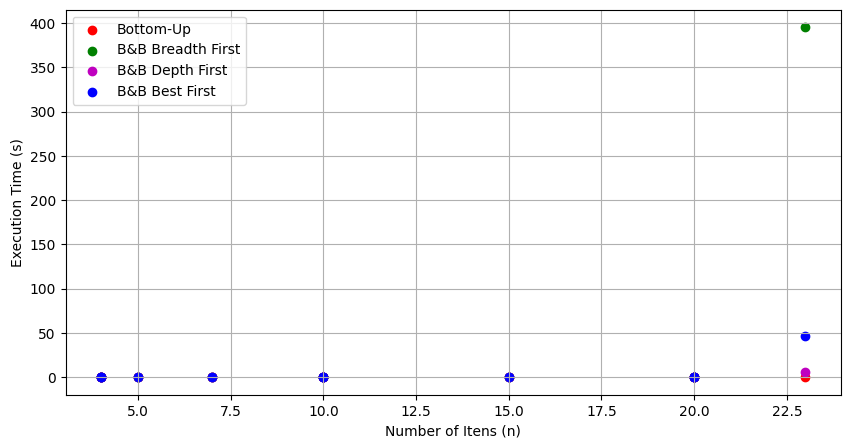

In [40]:
methods = {
    "Bottom-Up": knapsack_BU,
    "B&B Breadth First": KPBB_BreadthFirst,
    "B&B Depth First": KPBB_DepthFirst,
    "B&B Best First": KPBB_BestFirst
}

# Dic to store exec times
times = {method: [] for method in methods}
n_values = []

for dataset in datasets:
    n = int(dataset[0][0])
    wmax = dataset[0][1] 
    itens = dataset[1:]
    weights = dataset[1:, 1]
    values = dataset[1:, 0]

    print(f"\n=== Problem with {n:.0f} items and {wmax:.0f} capacity ===")
    
    for method_name, method in methods.items():
        tic = time.perf_counter()

        if method_name == "Bottom-Up":
            bestValue, n_it = method(itens, wmax)  
            bestTaken = None
        else:
            knapsack_solver = method(wmax, values, weights)
            bestValue, bestTaken, n_it = knapsack_solver.solve()

        toc = time.perf_counter()
        times[method_name].append(toc - tic)
        print(f"{method_name} = {(toc - tic):.4f}s, {n_it} iterations")

    n_values.append(n)
    print("Best value found:", bestValue)
    print("Chosen itens:", bestTaken)

# Plot exec times
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'm', 'b'] 

for (method_name, method_times), color in zip(times.items(), colors):
    plt.scatter(n_values, method_times, marker='o', linestyle='-', color=color, label=method_name)

plt.xlabel("Number of Itens (n)")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.grid(True)
plt.show()

<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    We can observe that the n=23 test presented an execution time that was significantly higher than the others, especially for the Breadth First and Best First methods. Since this test involved the largest number of items and the highest capacity, it also required the highest number of nodes to be calculated, which explains this discrepancy.
  </p>
  <p>
    If an dataset has a big n and a small capacity, it doesn't need a lot of iterations to reach the optimum result, since the backpack will be filled quickly. That is what happens in n=20, for example. 
  </p>
</div>

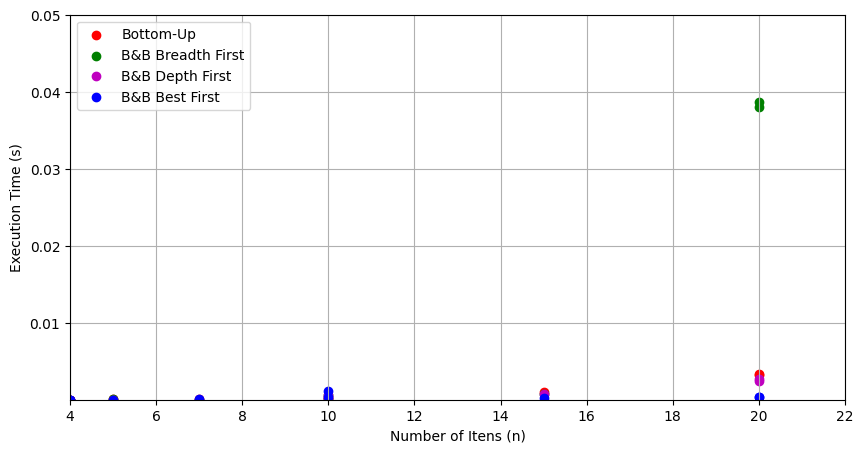

In [41]:
# Plot exec times
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'm', 'b'] 

for (method_name, method_times), color in zip(times.items(), colors):
    plt.scatter(n_values, method_times, marker='o', linestyle='-', color=color, label=method_name)

plt.xlim([min(n_values), 22.0])  
plt.ylim([min(method_times), 0.05])  
plt.xlabel("Number of Itens (n)")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.grid(True)
plt.show()

<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    Ignoring the result of this last test, we can also notice an increase in execution time as n grows, but at a much smaller scale. The Breadth First method remains the slowest, as it calculates nodes in a non-optimized manner (calculating unnecessary nodes). On the other hand, the Best First method proved to be the most efficient, even outperforming the Bottom-up method in some cases.
  </p>
  <p>
    The Bottom Up method always has a number of iterations iqual to the number of itens (n), while the B&B methods can reach a maximum number of iterations equal to 2<sup>n</sup>, but the actual number is smaller, because the method cut some branches. The efficiency in cutting branches varies a lot depending on the dataset, and it is the factor that defines the performance. Therefore, no method is the best for every scenario. 
  </p>
</div>

#### Large Scale

In [7]:
datasets = []
N_values = []
W_values = []
listing = os.listdir("./instances_01_KP/large_scale/")
my_array=np.zeros(shape=(0,5))
for infile in listing:
    print(infile)
    path = os.path.join("./instances_01_KP/large_scale/", infile)
    
    parts = infile.split("_")
    N = int(parts[2])  
    W = int(parts[3])  
    
    N_values.append(N)
    W_values.append(W)

    with open(path, "r") as f:
        lines = f.readlines()[:-1]  
    
    data = np.loadtxt(lines)
    datasets.append(data)
    break

In [13]:
def timeout_handler(num, stack):
    raise Exception("Timeout")

methods = {
    "Bottom-Up": knapsack_BU, 
    "B&B Best First": KPBB_BestFirst,
    # "B&B Depth First": KPBB_DepthFirst,
    # "B&B Breadth First": KPBB_BreadthFirst
}

# Dic to store exec times
times = {method: [] for method in methods}
n_values = []

for dataset in datasets:
    n = dataset[0][0] 
    wmax = dataset[0][1]
    itens = dataset[1:]
    weights = dataset[1:, 1]
    values = dataset[1:, 0]

    print(f"\n=== Problem with {n:.0f} items and {wmax:.0f} capacity ===")
    
    for method_name, method in methods.items():
        tic = time.perf_counter()

        if method_name == "Bottom-Up":
            bestValue, n_it = method(itens, wmax)
            bestTaken = None
        else:
            signal.signal(signal.SIGALRM, timeout_handler)
            signal.alarm(180)
            try:
                knapsack_solver = method(wmax, values, weights)
                bestValue, bestTaken, n_it = knapsack_solver.solve()
            except Exception as ex:
                print("\nB&B interrupted after 3min")

        toc = time.perf_counter()
        times[method_name].append(toc - tic)
        print(f"{method_name} = {(toc - tic):.4f}s, {n_it} iterations")

    n_values.append(n)
    print("Best value found:", bestValue)
    print("Chosen itens:", bestTaken)


=== Problem with 200 items and 1008 capacity ===
Bottom-Up = 0.0266s, 200 iterations

B&B interrupted after 3min
B&B Best First = 60.0002s, 200 iterations
Best value found: 11238.0
Chosen itens: None


<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    For the test on a Large Scale dataset, the test was conducted only for the Best First method, as it proved to be the most efficient in the Low Dimensional examples, but the run was interrupted after running for 30min. 
  </p>
  <p>
    We can see that the B&B method has an execution time significantly higher than the Bottom-up method, that gave us a result in less than a second. This was expected, given the substantial increase in execution time of B&B methods observed in the Low Dimensional examples.
  </p>
</div>